# t-SNE analysis


In [1]:
%load_ext autoreload
%autoreload 2

### Imports and load the policy

Note: you need to install the `sklearn` library to run this example: `uv pip install scikit-learn`

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.manifold import TSNE

from routefinder.envs.mtvrp import MTVRPEnv, MTVRPGenerator
from routefinder.models import RouteFinderBase

PATH = "../checkpoints/100/rf-transformer.ckpt"
model = RouteFinderBase.load_from_checkpoint(PATH, map_location="cpu")

# PATH = "../checkpoints/100/mtpomo.ckpt"
# model = MTPOMO.load_from_checkpoint(PATH, map_location="cpu")

# PATH = "../checkpoints/100/mvmoe.ckpt"
# model = MVMoE.load_from_checkpoint(PATH, map_location="cpu")


policy = model.policy

# Sample all variants in the same batch (Mixed-Batch Training)

variants = ["cvrp", "ovrp", "vrpb", "vrpl", "vrptw", "ovrptw", "ovrpb", "ovrpl", "vrpbl", "vrpbtw", "vrpltw", "ovrpbl", "ovrpbtw", "ovrpltw", "vrpbltw", "ovrpbltw"]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
policy = policy.to(device).eval()

/home/botu/Dev/routefinder/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/botu/Dev/routefinder/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/botu/Dev/routefinder/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.
Provided file name ['data/cvrp/val/100.npz', 'data/ovrp/val/100.npz', 'data/ovrpb/val/100.npz', 'data/ovrpbl/val/100.npz', 'data/ovrpbltw/val/100.npz', 'data/ovrpbtw/val

### Run inference to collect embeddings $h$ for each layer

In [3]:


# Assuming 'policy' is your RouteFinderPolicy instance
encoder = policy.encoder.eval()
# Set the number of samples per variant
SAMPLES_PER_VARIANT = 100

if getattr(encoder, 'net', None) is None:
    layers = encoder.layers
else:
    layers = encoder.net.layers

# Function to get encoded representations for each layer
def get_encoded_repr_by_layer(td_data, env):
    with torch.inference_mode():
        td_test = env.reset(td_data.clone())
        h = encoder.init_embedding(td_test.to(device))
        layer_outputs = []
        for layer in layers:
            h = layer(h)
            layer_outputs.append(h.cpu().numpy())
    return layer_outputs

# Collect encoded representations for all variants and layers
all_encodings_by_layer = [[] for _ in range(len(layers))]
all_labels = []

for variant in variants:
    generator = MTVRPGenerator(num_loc=100, variant_preset=variant)
    env = MTVRPEnv(generator, check_solution=False)
    # Generate data (mixed variants)
    td_data = env.generator(SAMPLES_PER_VARIANT)
    variant_names = env.get_variant_names(td_data)
    # Get encoded representations for each layer
    encodings_by_layer = get_encoded_repr_by_layer(td_data, env)
    for layer, encodings in enumerate(encodings_by_layer):
        # Use mean encoding across nodes for each instance
        mean_encodings = encodings.mean(axis=1)
        all_encodings_by_layer[layer].append(mean_encodings)
    all_labels.extend([variant] * len(td_data))

# Combine all encodings for each layer
all_encodings_by_layer = [np.concatenate(encodings, axis=0) for encodings in all_encodings_by_layer]

### Perform T-SNE on the embeddings

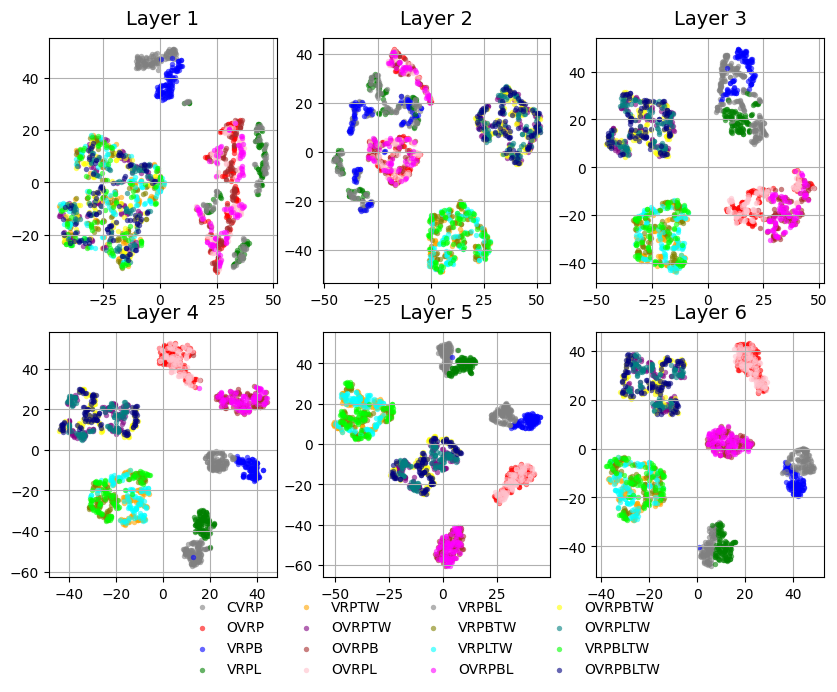

In [ ]:
## Uncomment only if you have Latex installed
## Ensure the LaTeX-style fonts are used
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Computer Modern Roman"],
# })


color_palette = ['grey', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive',
 'cyan', 'magenta', 'yellow', 'teal', 'lime', 'navy', 'gold']

# Create TSNE plots for each layer
num_layers = len(all_encodings_by_layer)
fig, axes = plt.subplots(2, (num_layers + 1) // 2, figsize=(10, 7))
axes = axes.flatten()

for layer, encodings in enumerate(all_encodings_by_layer):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(encodings)

    ax = axes[layer]
    # Plot TSNE results for each variant using the color palette
    for i, variant in enumerate(variants):
        variant_points = tsne_results[np.array(all_labels) == variant]
        # Rasterize dots for more efficient rendering
        ax.scatter(variant_points[:, 0], variant_points[:, 1], color=color_palette[i],
                   label=variant.upper(), alpha=.6, s=15, linewidth=0, rasterized=True)

    ax.set_title(f"Layer {layer + 1}", fontsize=14, pad=10)  # Larger, well-spaced titles
    ax.grid(True)


# Remove any unused subplots
for i in range(num_layers, len(axes)):
    fig.delaxes(axes[i])

# Create a clean, well-positioned legend
handles, labels = axes[0].get_legend_handles_labels()
ncol = (len(variants) + 1) // 4  # Adjust number of legend columns
fig.legend(handles, labels, loc='lower center', ncol=ncol, bbox_to_anchor=(0.5, -0.05), fontsize=10, frameon=False)

# Save as a PDF, suitable for preview with rasterized dots
# plt.savefig("tsne.pdf", dpi=150, bbox_inches='tight')
plt.show()